In [1]:
import itertools
import os
from pathlib import Path
import subprocess
import sys

from Bio import SeqIO
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
from scipy.spatial.distance import hamming
import seaborn as sns
from tqdm.notebook import tqdm

sys.path.append('../../bitome2')
sys.path.append('../')

from bitome.core import Bitome
from feature_functions import *

# Load E. coli K-12 MG1655 Bitome

In [2]:
K12_DATA_PATH = Path('../data/bitome2/mg1655')
# from GenBank annotation
origin = (3925743, 3925975)
# from 1. Duggin, I. G. & Bell, S. D. J. Mol. Biol. (2009). with the following terA/terC sequences:
# ter_a = 'AATTAGTATGTTGTAACTAAAGT'
# ter_c = 'ATATAGGATGTTGTAACTAATAT'
terminus = (1341745, 1609180)

In [3]:
mg1655 = Bitome(
    Path(K12_DATA_PATH, 'NC_000913.3.gb'),
    origin=origin, terminus=terminus,
    gene_table=Path(K12_DATA_PATH, 'gene_info_supp.csv'),
    tu_table=Path(K12_DATA_PATH, 'tu.csv'),
    operon_table=Path(K12_DATA_PATH, 'operon.csv'),
    tss_table=Path(K12_DATA_PATH, 'tss.csv'),
    # TODO PARSE TTS data
    tts_table=None,
    tfbs_table=Path(K12_DATA_PATH, 'tfbs.csv'),
    terminator_table=Path(K12_DATA_PATH, 'terminator.csv'),
    attenuator_table=Path(K12_DATA_PATH, 'attenuator.csv'),
    rbs_table=Path(K12_DATA_PATH, 'rbs.csv'),
    riboswitch_table=Path(K12_DATA_PATH, 'riboswitch.csv')
)

# Load multi strain

In [4]:
bitomes_by_id = {}

genome_dir = Path('..', 'data', 'e_coli_genomes', 'refseq')

for file in os.listdir(genome_dir):
    gb_id = file.split('.')[0]
    bitome = Bitome(Path(genome_dir, file))
    bitomes_by_id[bitome.reference_id] = bitome

In [5]:
[(b.description, b.reference_id) for b in bitomes_by_id.values()]

[('Escherichia coli BL21(DE3), complete genome', 'NC_012971.2'),
 ('Escherichia coli ATCC 8739, complete genome', 'NC_010468.1'),
 ('Escherichia coli CFT073, complete genome', 'NC_004431.1'),
 ('Escherichia coli str. K-12 substr. W3110 DNA, complete genome',
  'NC_007779.1'),
 ('Escherichia coli KO11FL, complete genome', 'NC_017660.1'),
 ('Escherichia coli 042 complete genome', 'NC_017626.1'),
 ('Escherichia coli O157:H7 str. Sakai, complete genome', 'NC_002695.1'),
 ('Escherichia coli W, complete genome', 'NC_017635.1')]

In [6]:
id_to_name = {
    'NC_004431.1': 'CFT073','NC_017626.1': '042','NC_007779.1': 'W3110',
    'NC_002695.1': 'O157:H7','NC_010468.1': 'Crooks','NC_017660.1': 'KO11FL',
    'NC_012971.2': 'BL21','NC_017635.1': 'W'
}

In [7]:
BLAST_PATH = Path('../data/multi_strain_blast/')

In [8]:
strains_to_check = ['042','BL21','CFT073','Crooks','KO11FL','W','W3110'];

In [11]:
column_names = [
    'mg_tu_id', 'strain_id', 'percent', 'align_length', 'n_mismatch', 'n_gapopen',
    'mg_start', 'mg_end', 'strain_start', 'strain_end', 'e_value', 'bit_score'
]

multi_strain_tu_rows = []

for strain_id, bitome in bitomes_by_id.items():
    
    # read in the file, add column names
    blast_report_df = pd.read_csv(Path(BLAST_PATH, f'{strain_id}.csv'), header=0, names=column_names)
    
    # move through and only keep the best match by TU
    for tu_id, tu_blast_df in blast_report_df.groupby('mg_tu_id'):
     
        mg_tu_info = mg1655.tu_table[mg1655.tu_table.index == tu_id][[
            'left', 'right', 'strand', 'tss']].drop_duplicates().T.squeeze()
        mg_tu_len = int(mg_tu_info['right'] - mg_tu_info['left'] + 1)
        
        if pd.isna(mg_tu_info['tss']):
            if mg_tu_info['strand'] == 1:
                mg_tss = mg_tu_info['left']
            else:
                mg_tss = mg_tu_info['right']
        else:
            mg_tss = int(mg_tu_info['tss'])
        
        # best match starts at the same point as the MG TU
        matches_from_start = tu_blast_df[(tu_blast_df['mg_start'] == 1) &
                                       ( (tu_blast_df['mg_end'] == mg_tu_len) | (tu_blast_df['mg_end'] > 200 ) )]
        
        matches_from_start = matches_from_start.sort_values(by='mg_end', ascending=False)
        if not matches_from_start.empty:
            strain_start, strain_end = matches_from_start.iloc[0, :][['strain_start', 'strain_end']].values
            if strain_start < strain_end:
                strain_tss = strain_start
                strain_strand = 1
                length = strain_end - strain_start
            else:
                strain_tss = strain_end
                strain_strand = -1
                length = strain_start - strain_end
            
            tu_match_row = [matches_from_start.iloc[0, :]['mg_tu_id'], mg_tss,
                            int(mg_tu_info['strand']),
                           strain_id, strain_tss, strain_strand, id_to_name[strain_id], length ]
            multi_strain_tu_rows.append(tu_match_row)
    
multi_strain_tu_df = pd.DataFrame(multi_strain_tu_rows, 
                                  columns=['mg_tu_id', 'mg_tss', 'mg_tss_strand',
                                           'strain_id', 'strain_tss', 'strain_tss_strand',
                                           'strain_name', 'strain_tu_length'])

In [13]:
multi_strain_tu_df = multi_strain_tu_df.sort_values(by='strain_name')
multi_strain_tu_df = multi_strain_tu_df.reset_index()
multi_strain_tu_df  = multi_strain_tu_df.drop(columns=['index'])
multi_strain_tu_df.head()

,mg_tu_id,mg_tss,mg_tss_strand,strain_id,strain_tss,strain_tss_strand,strain_name,strain_tu_length
0,ECK120034112,3322587,-1,NC_017626.1,3690871,-1,042,552
1,ECK120009316,3109175,-1,NC_017626.1,3383785,-1,042,2155
2,ECK120009317,3267093,-1,NC_017626.1,3629254,-1,042,8808
3,ECK120009318,2339539,1,NC_017626.1,2611410,1,042,746
4,ECK120009319,3222551,1,NC_017626.1,3593565,1,042,3620


In [14]:
mg1655_tus = mg1655.tu_table

In [15]:
tu_match_length = {}
for strain_name in strains_to_check:
    tu_match_length[strain_name] = [[],[] ]
    sub_table = multi_strain_tu_df[ multi_strain_tu_df['strain_name'] == strain_name ]
    tu_ids = list(sub_table['mg_tu_id'])
    tu_lengths = list(sub_table['strain_tu_length'])
    for i in range(len(tu_ids)):
        temp_length = abs(mg1655_tus[mg1655_tus.index == tu_ids[i]]['left'][0] 
                          - mg1655_tus[mg1655_tus.index == tu_ids[i]]['right'][0] )
        tu_match_length[strain_name][0].append( temp_length)
        tu_match_length[strain_name][1].append(tu_lengths[i])   

(0.0, 1.0, 0.0, 1.0)

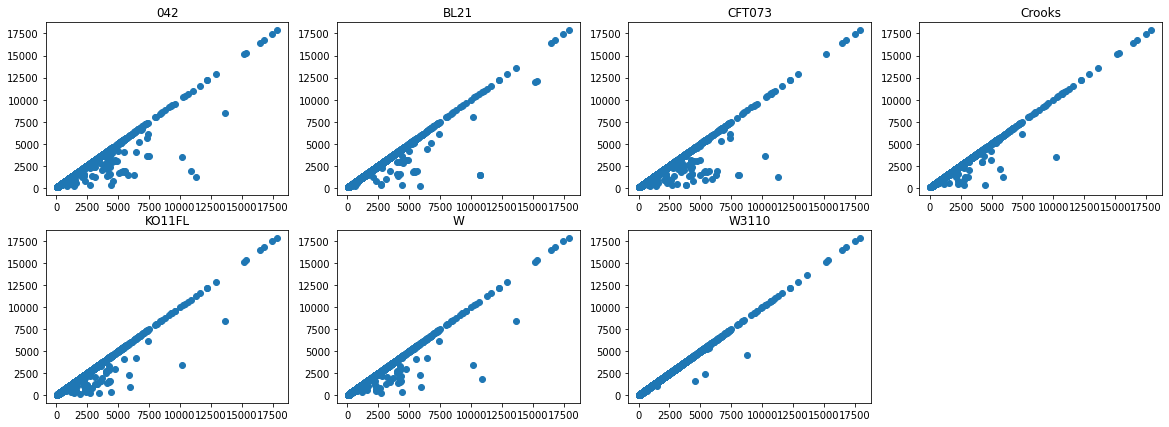

In [16]:
fig,axs = plt.subplots(2,4,figsize=(20,7))
for i in range(len(strains_to_check)):
    strain_name = strains_to_check[i]
    x = int(i/4);
    y = int(i%4);
    axs[x][y].scatter( tu_match_length[strain_name][0], tu_match_length[strain_name][1] )
    axs[x][y].set_title(strain_name)
axs[-1][-1].axis('off')    

In [17]:
multi_strain_tu_df = pd.read_csv('../data/Fur_multistrain_SN/multi_strain_tu_df.csv')
multi_strain_tu_df.head()

,mg_tu_id,mg_tss,mg_tss_strand,strain_id,strain_tss,strain_tss_strand,strain_name,strain_tu_length
0,ECK120026943,1441780,-1,NC_017626.1,1590494,-1,042,459
1,ECK120026819,1067758,-1,NC_017626.1,1165237,-1,042,894
2,ECK120026926,1408024,1,NC_017626.1,1529719,1,042,1009
3,ECK120026924,1398659,-1,NC_017626.1,1519367,-1,042,987
4,ECK120026919,1392072,-1,NC_017626.1,1513115,-1,042,1139


# create tu tables for bitome objects

In [18]:
gene_tu_map = pd.read_csv('../data/Fur_multistrain_SN/gene_tu_mapping.csv')

In [19]:
def get_TUname( tu_id, gene_tu_map ):
    sub = gene_tu_map[  gene_tu_map['tu_id'] == tu_id]
    if len( np.unique(sub['tu_name']) ) < 1:
        tuname = None
    else:
        tuname = np.unique(sub['tu_name'])[0]
    return tuname

def get_LR( tss, length, strand ):
    if strand == 1:
        left = tss
        right = tss+length
    else:
        right = tss
        left = right - length
    return (left,right)

In [20]:
tu_columns = ['locus_tag','name', 'strand', 'tss', 'sigma_factor', 'box_10_left', 'box_10_right',
              'box_35_left', 'box_35_right', 'left', 'right']

tu_tables_byid = {}

for strain_id in list(id_to_name.keys()):
    sub_table = multi_strain_tu_df[ multi_strain_tu_df['strain_id'] == strain_id ]
    tu_length = list(sub_table['strain_tu_length'])
    locus_tag = list(sub_table['mg_tu_id'])
    name_list = [ get_TUname(locus_tag[i],gene_tu_map) for i in range(len(locus_tag))]
    strand = list(sub_table['strain_tss_strand'])
    tss_list = list(sub_table['strain_tss'])
    empty= [ None for i in range(len(locus_tag))]
    left,right = [],[]
    for i in range(len(tss_list)):
        lr = get_LR( tss_list[i], tu_length[i], strand[i] )
        left.append(lr[0])
        right.append(lr[1])
    temp_pd = pd.DataFrame(list(zip(locus_tag,name_list,strand,tss_list,
                                   empty, empty, empty, empty, empty,left,right)),  columns = tu_columns )
        
    temp_pd = temp_pd.dropna(subset=['name'])
    temp_pd = temp_pd.reset_index()
    temp_pd= temp_pd.drop(columns=['index'])
    tu_tables_byid[ strain_id] = temp_pd

In [21]:
for strain_id in list(id_to_name.keys()):
    temp_id = strain_id[0:-2] +'_' + strain_id[-1];
    temp_table = tu_tables_byid[strain_id]
    temp_table.to_csv('../data/Fur_multistrain_SN/'+temp_id+'/tu.csv')

#  Assign TU

In [9]:
bitomes_by_id = {}

genome_dir = Path('..', 'data', 'e_coli_genomes', 'refseq')

for file in os.listdir(genome_dir):
    gb_id = file.split('.')[0]
    bitome = Bitome(Path(genome_dir, file))
    b_id = bitome.reference_id
    tu_table_path = Path('../data/Fur_multistrain_SN/'+b_id[0:-2] +'_' + b_id[-1], 'tu.csv')
    bitome = Bitome(Path(genome_dir, file), tu_table= tu_table_path)
    bitomes_by_id[bitome.reference_id] = bitome

In [10]:
strains = ['042','BL21','CFT073','Crooks','KO11FL','Sakai','W','W3110'];
Fur_multi_table = {}
for strain in strains:
    temp = pd.read_csv('../data/Fur_multistrain_SN/ecoli_'+strain+'_SN.csv')
    rm_list = []
    #filter too large sites
    for i in range(len(temp.index) ):
        if abs( temp['ChIP-exo End'][i] - temp['ChIP-exo Start'][i] ) > 50:
            rm_list.append(i)      
    temp = temp.drop(rm_list)
    temp = temp.dropna()
    temp = temp.reset_index()
    temp = temp.drop(columns=['index'])
    Fur_multi_table[strain] = temp

In [11]:
name_to_id = {}
for ID in id_to_name.keys():
    name_to_id[ id_to_name[ID]] = ID
    
strains_to_check = ['042','BL21','CFT073','Crooks','KO11FL','W','W3110'];


for strain_name in strains_to_check:
    sn_table = Fur_multi_table[strain_name]
    tu_list = []
    tu_name_list =[]
    for i in range(len(sn_table['ChIP-exo Start'])):
        start = list(sn_table['ChIP-exo Start'])[i]
        end = list(sn_table['ChIP-exo End'])[i]
        temp_table = bitomes_by_id[  name_to_id[strain_name] ].features_in_range(start,end)
        if len(temp_table.index) < 1:
            tu_list.append(None)
            tu_name_list.append(None)
        else:
            sub = temp_table[temp_table['type']=='tu']
            if len(sub['name']) < 1:
                tu_list.append(None)
                tu_name_list.append(None)
            else:
                tu_list.append( sub.index[0])
                tu_name_list.append( sub['name'][0] )
            
    sn_table['tu_id'] = tu_list
    sn_table['tu_name'] = tu_name_list
    sn_table = sn_table.dropna()
    sn_table = sn_table.reset_index()
    sn_table = sn_table.drop(columns=['index'])
    Fur_multi_table[strain_name] = sn_table

In [12]:
# resolve multiple chip results
for strain_name in strains_to_check:
    sn_table = Fur_multi_table[strain_name]
    keep_list = []
    unique_tus = list( set(sn_table['tu_id'] ) )
    for tuid in unique_tus:
        temp = sn_table[sn_table['tu_id']==tuid]
        if len(temp['tu_id']) == 1:
            keep_list.append(  temp.index[0])
        else:
            max_index = list(temp['S/N ratio']).index( max( list(temp['S/N ratio']) ))
            keep_list.append( temp.index[max_index] )
    sn_table = sn_table.iloc[ keep_list ]
    sn_table = sn_table.reset_index()
    sn_table = sn_table.drop(columns=['index'])
    Fur_multi_table[strain_name] = sn_table

In [13]:
TF_SN = pd.read_csv('../data/all_tf_data.csv')
TF_SN = TF_SN[['TF','SN_ratio','TU','start','stop','log_SN']]
mg1655_SN = TF_SN.iloc[0:143]

(0.0, 1.0, 0.0, 1.0)

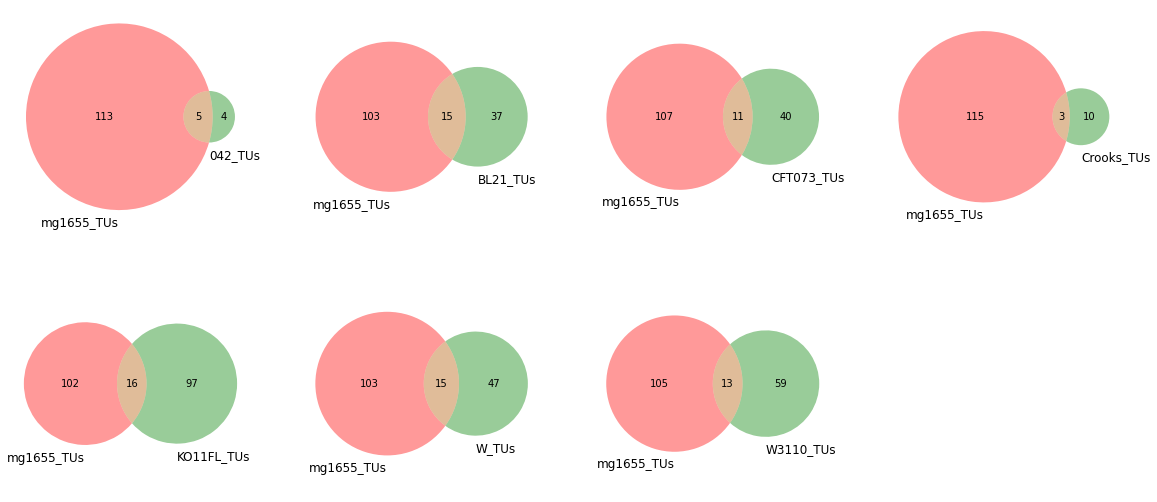

In [30]:
from matplotlib_venn import venn2
fig,axs = plt.subplots(2,4,figsize=(20,9))
for i in range(len(strains_to_check)):
    strain_name = strains_to_check[i]
    x = int(i/4)
    y = int(i%4)
    sn_table = Fur_multi_table[strain_name]
    strain_tu = list( set( sn_table['tu_name'] ) )
    venn2([set( mg1655_SN['TU']),set(strain_tu)],set_labels = ('mg1655_TUs',strain_name+'_TUs'),ax =axs[x][y])
axs[-1][-1].axis('off')

In [14]:
gene_tu_map = pd.read_csv('../data/Fur_multistrain_SN/gene_tu_mapping.csv')
def get_geneTU( tu_name, gene_tu_map ):
    sub = gene_tu_map[gene_tu_map['tu_name'] == tu_name]
    if len(sub['gene_id']) < 1:
        return []
    else:
        return list( set( sub['gene_id'] ) )   

(0.0, 1.0, 0.0, 1.0)

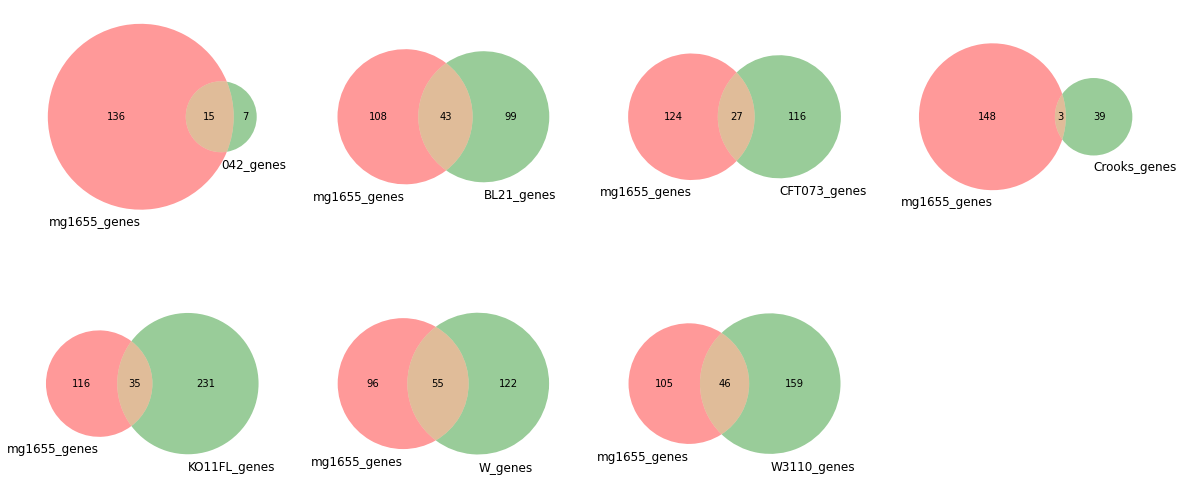

In [32]:
SN_genes = {}
from matplotlib_venn import venn2
fig,axs = plt.subplots(2,4,figsize=(20,9))
for i in range(len(strains_to_check)):
    strain_name = strains_to_check[i]
    x = int(i/4)
    y = int(i%4)
    sn_table = Fur_multi_table[strain_name]
    strain_tu = list( set( sn_table['tu_name'] ) )
    mg_tu = list( set(mg1655_SN['TU']) )
    strain_genes = []
    mg_genes = []
    for i in range( len(strain_tu)):
        strain_genes += get_geneTU( strain_tu[i], gene_tu_map )
    for j in range(len(mg_tu)):
        mg_genes += get_geneTU( mg_tu[j], gene_tu_map)
    SN_genes['mg1655'] = mg_genes
    SN_genes[ strain_name ] = strain_genes
    venn2([set( mg_genes ),set(strain_genes)],set_labels = ('mg1655_genes',strain_name+'_genes'),ax =axs[x][y])
    
axs[-1][-1].axis('off')

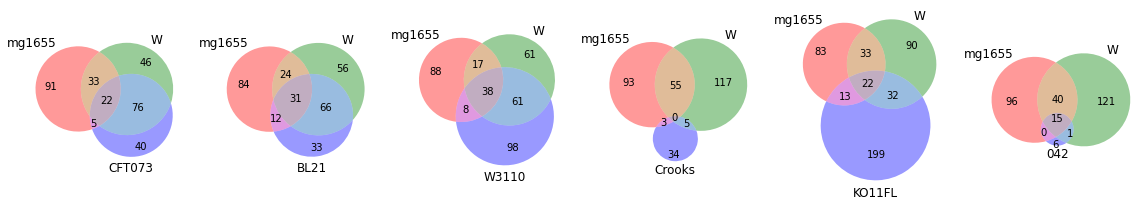

In [33]:
from matplotlib_venn import venn3, venn3_circles
fig,axs = plt.subplots(1,6, figsize=(20,5))
venn3([set(SN_genes['mg1655']),set(SN_genes['W']),set(SN_genes['CFT073'])], 
      set_labels = ('mg1655', 'W', 'CFT073'), ax = axs[0]);

venn3([set(SN_genes['mg1655']),set(SN_genes['W']),set(SN_genes['BL21'])], 
      set_labels = ('mg1655', 'W', 'BL21'), ax = axs[1]);

venn3([set(SN_genes['mg1655']),set(SN_genes['W']),set(SN_genes['W3110'])], 
      set_labels = ('mg1655', 'W', 'W3110'), ax = axs[2]);

venn3([set(SN_genes['mg1655']),set(SN_genes['W']),set(SN_genes['Crooks'])], 
      set_labels = ('mg1655', 'W', 'Crooks'), ax = axs[3]);

venn3([set(SN_genes['mg1655']),set(SN_genes['W']),set(SN_genes['KO11FL'])], 
      set_labels = ('mg1655', 'W', 'KO11FL'), ax = axs[4]);

venn3([set(SN_genes['mg1655']),set(SN_genes['W']),set(SN_genes['042'])], 
      set_labels = ('mg1655', 'W', '042'), ax = axs[5]);

(0.0, 1.0, 0.0, 1.0)

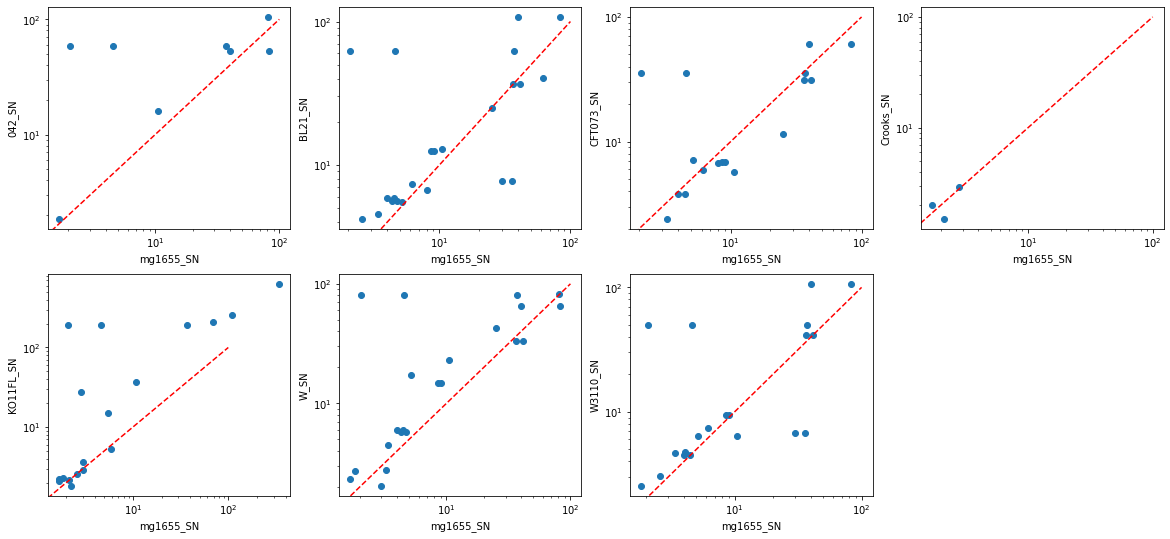

In [34]:
fig,axs = plt.subplots(2,4,figsize=(20,9))
for i in range(len(strains_to_check)):
    strain_name = strains_to_check[i]
    x = int(i/4)
    y = int(i%4)
    sn_table = Fur_multi_table[strain_name]
    strain_tu = list( set( sn_table['tu_name'] ) )
    mg_tu = list( set(mg1655_SN['TU']) )
    common_tus = list( set(strain_tu) & set(mg_tu) )
    keep_strain = []
    keep_mg = []
    for k in range(len(sn_table['tu_name'])):
        if list(sn_table['tu_name'])[k] in common_tus:
            keep_strain.append(k)
    for j in range(len(mg1655_SN['TU'])):
        if list(mg1655_SN['TU'])[j] in common_tus:
            keep_mg.append(j)
    sub_mg_pd = mg1655_SN.iloc[keep_mg,:]
    sub_mg_pd = sub_mg_pd.rename(columns={'TU':'tu_name'})
    sub_strain_pd = sn_table.iloc[keep_strain,:]
    merge_sub = sub_strain_pd.merge(sub_mg_pd, on='tu_name')
    merge_sub = merge_sub.dropna()
    strain_sn = list(merge_sub['S/N ratio'])
    mg_sn = list(merge_sub['SN_ratio'])
    axs[x][y].scatter(mg_sn, strain_sn)
    axs[x][y].set_xlabel('mg1655_SN')
    axs[x][y].set_ylabel(strain_name+'_SN')
    axs[x][y].plot([0, 100], [0, 100], ls='--',color='r')
    axs[x][y].set_yscale('log')
    axs[x][y].set_xscale('log')

axs[-1][-1].axis('off')

(0.0, 1.0, 0.0, 1.0)

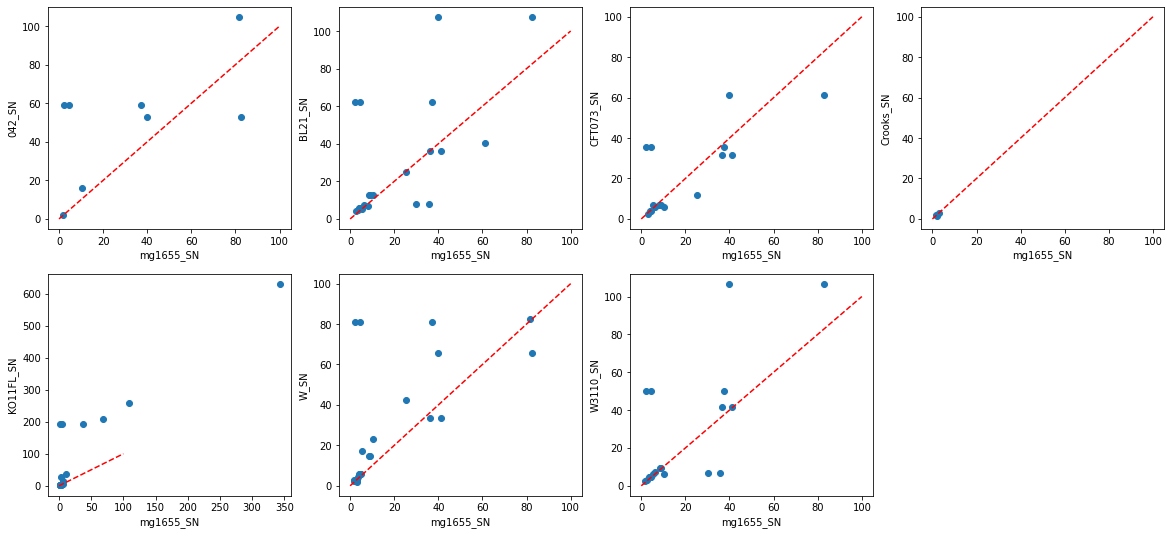

In [35]:
fig,axs = plt.subplots(2,4,figsize=(20,9))
for i in range(len(strains_to_check)):
    strain_name = strains_to_check[i]
    x = int(i/4)
    y = int(i%4)
    sn_table = Fur_multi_table[strain_name]
    strain_tu = list( set( sn_table['tu_name'] ) )
    mg_tu = list( set(mg1655_SN['TU']) )
    common_tus = list( set(strain_tu) & set(mg_tu) )
    keep_strain = []
    keep_mg = []
    for k in range(len(sn_table['tu_name'])):
        if list(sn_table['tu_name'])[k] in common_tus:
            keep_strain.append(k)
    for j in range(len(mg1655_SN['TU'])):
        if list(mg1655_SN['TU'])[j] in common_tus:
            keep_mg.append(j)
    sub_mg_pd = mg1655_SN.iloc[keep_mg,:]
    sub_mg_pd = sub_mg_pd.rename(columns={'TU':'tu_name'})
    sub_strain_pd = sn_table.iloc[keep_strain,:]
    merge_sub = sub_strain_pd.merge(sub_mg_pd, on='tu_name')
    merge_sub = merge_sub.dropna()
    strain_sn = list(merge_sub['S/N ratio'])
    mg_sn = list(merge_sub['SN_ratio'])
    axs[x][y].scatter(mg_sn, strain_sn)
    axs[x][y].set_xlabel('mg1655_SN')
    axs[x][y].set_ylabel(strain_name+'_SN')
    axs[x][y].plot([0, 100], [0, 100], ls='--',color='r')

axs[-1][-1].axis('off')

(0.0, 1.0, 0.0, 1.0)

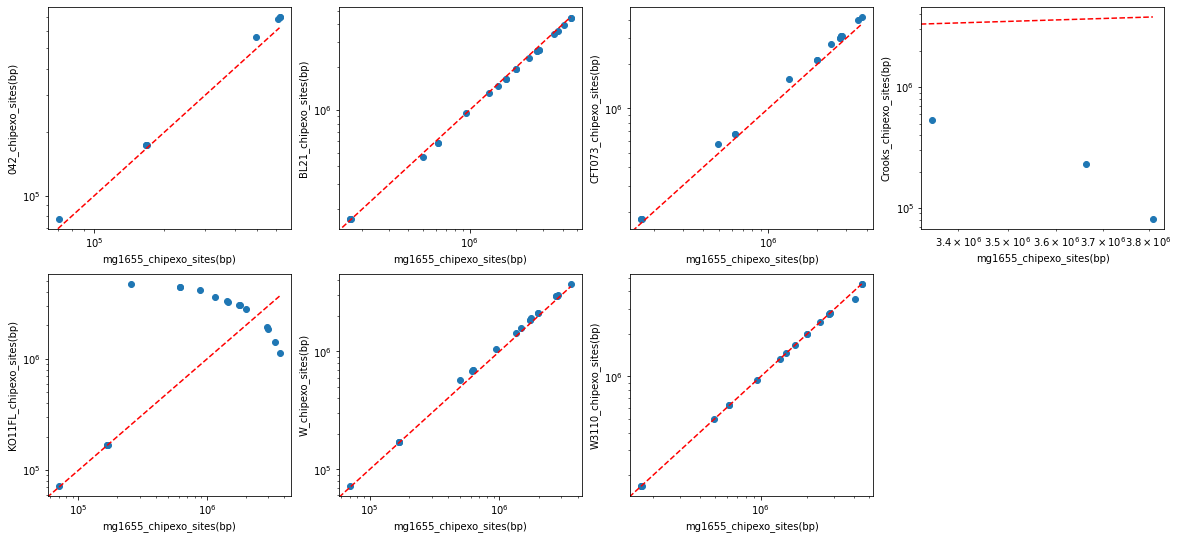

In [36]:
fig,axs = plt.subplots(2,4,figsize=(20,9))
for i in range(len(strains_to_check)):
    strain_name = strains_to_check[i]
    x = int(i/4)
    y = int(i%4)
    sn_table = Fur_multi_table[strain_name]
    strain_tu = list( set( sn_table['tu_name'] ) )
    mg_tu = list( set(mg1655_SN['TU']) )
    common_tus = list( set(strain_tu) & set(mg_tu) )
    keep_strain = []
    keep_mg = []
    for k in range(len(sn_table['tu_name'])):
        if list(sn_table['tu_name'])[k] in common_tus:
            keep_strain.append(k)
    for j in range(len(mg1655_SN['TU'])):
        if list(mg1655_SN['TU'])[j] in common_tus:
            keep_mg.append(j)
    sub_mg_pd = mg1655_SN.iloc[keep_mg,:]
    sub_mg_pd = sub_mg_pd.rename(columns={'TU':'tu_name'})
    sub_strain_pd = sn_table.iloc[keep_strain,:]
    merge_sub = sub_strain_pd.merge(sub_mg_pd, on='tu_name')
    merge_sub = merge_sub.dropna()
    mg_sites = [ ( list(merge_sub['stop'])[a]+ list(merge_sub['start'])[a] )/2 
                for a in range(len(merge_sub['stop'])) ]
    strain_sites = [ ( list(merge_sub['ChIP-exo Start'])[b]+ list(merge_sub['ChIP-exo End'])[b] )/2 
                for b in range(len(merge_sub['ChIP-exo Start'])) ]
    
    axs[x][y].scatter(mg_sites, strain_sites)
    axs[x][y].set_xlabel('mg1655_chipexo_sites(bp)')
    axs[x][y].set_ylabel(strain_name+'_chipexo_sites(bp)')
    axs[x][y].set_yscale('log')
    axs[x][y].set_xscale('log')
    axs[x][y].plot([0,max(mg_sites) ], [0,max(mg_sites) ], ls='--',color='r')

axs[-1][-1].axis('off')

(0.0, 1.0, 0.0, 1.0)

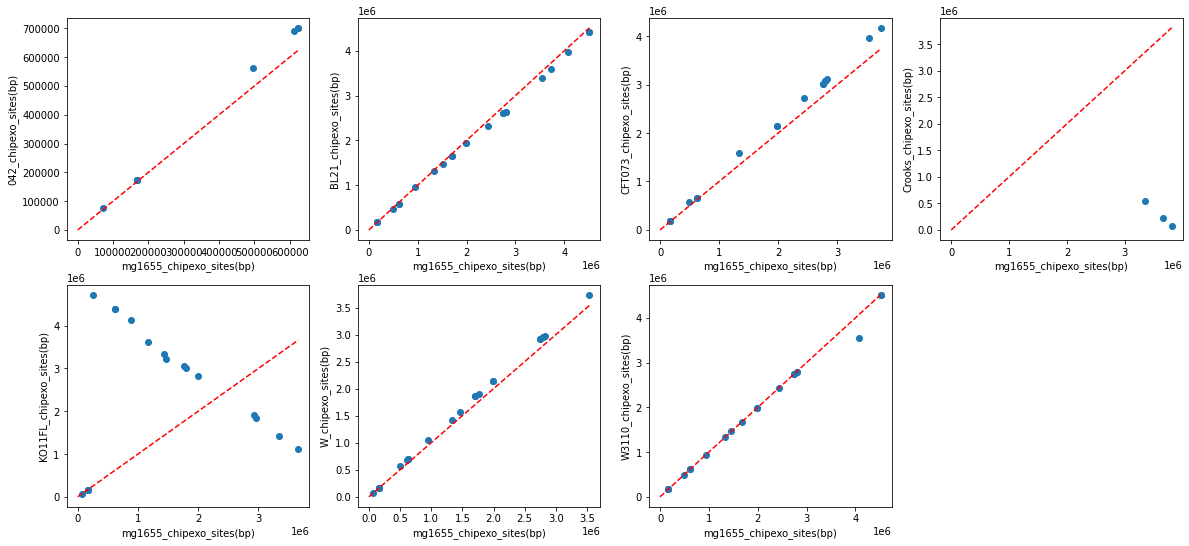

In [37]:
fig,axs = plt.subplots(2,4,figsize=(20,9))
for i in range(len(strains_to_check)):
    strain_name = strains_to_check[i]
    x = int(i/4)
    y = int(i%4)
    sn_table = Fur_multi_table[strain_name]
    strain_tu = list( set( sn_table['tu_name'] ) )
    mg_tu = list( set(mg1655_SN['TU']) )
    common_tus = list( set(strain_tu) & set(mg_tu) )
    keep_strain = []
    keep_mg = []
    for k in range(len(sn_table['tu_name'])):
        if list(sn_table['tu_name'])[k] in common_tus:
            keep_strain.append(k)
    for j in range(len(mg1655_SN['TU'])):
        if list(mg1655_SN['TU'])[j] in common_tus:
            keep_mg.append(j)
    sub_mg_pd = mg1655_SN.iloc[keep_mg,:]
    sub_mg_pd = sub_mg_pd.rename(columns={'TU':'tu_name'})
    sub_strain_pd = sn_table.iloc[keep_strain,:]
    merge_sub = sub_strain_pd.merge(sub_mg_pd, on='tu_name')
    merge_sub = merge_sub.dropna()
    mg_sites = [ ( list(merge_sub['stop'])[a]+ list(merge_sub['start'])[a] )/2 
                for a in range(len(merge_sub['stop'])) ]
    strain_sites = [ ( list(merge_sub['ChIP-exo Start'])[b]+ list(merge_sub['ChIP-exo End'])[b] )/2 
                for b in range(len(merge_sub['ChIP-exo Start'])) ]
    
    axs[x][y].scatter(mg_sites, strain_sites)
    axs[x][y].set_xlabel('mg1655_chipexo_sites(bp)')
    axs[x][y].set_ylabel(strain_name+'_chipexo_sites(bp)')
    #axs[x][y].set_yscale('log')
    #axs[x][y].set_xscale('log')
    axs[x][y].plot([0,max(mg_sites) ], [0,max(mg_sites) ], ls='--',color='r')

axs[-1][-1].axis('off')

(0.0, 1.0, 0.0, 1.0)

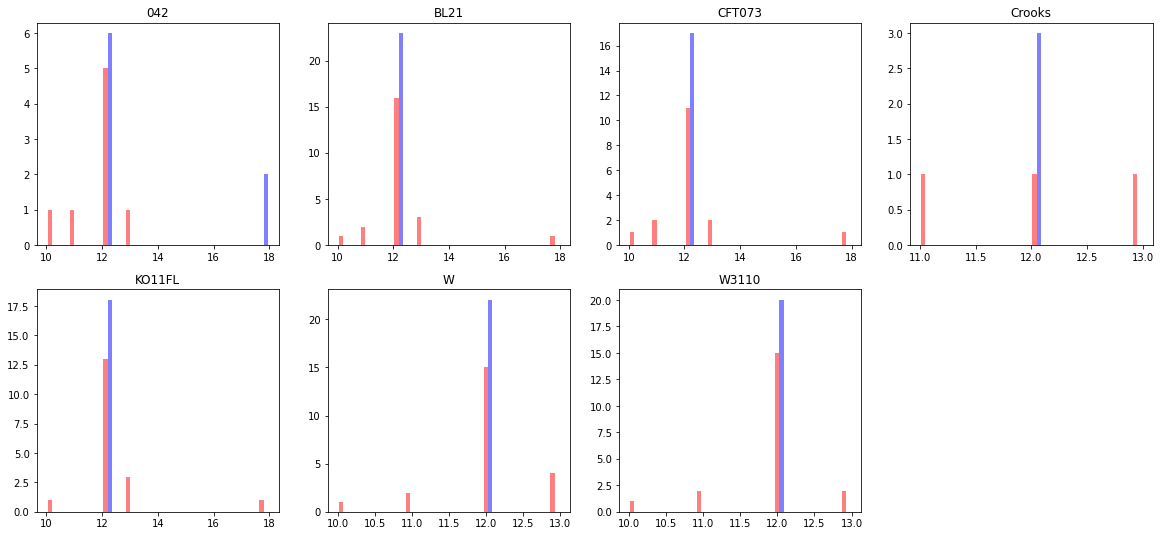

In [38]:
fig,axs = plt.subplots(2,4,figsize=(20,9))
for i in range(len(strains_to_check)):
    strain_name = strains_to_check[i]
    x = int(i/4)
    y = int(i%4)
    sn_table = Fur_multi_table[strain_name]
    strain_tu = list( set( sn_table['tu_name'] ) )
    mg_tu = list( set(mg1655_SN['TU']) )
    common_tus = list( set(strain_tu) & set(mg_tu) )
    keep_strain = []
    keep_mg = []
    for k in range(len(sn_table['tu_name'])):
        if list(sn_table['tu_name'])[k] in common_tus:
            keep_strain.append(k)
    for j in range(len(mg1655_SN['TU'])):
        if list(mg1655_SN['TU'])[j] in common_tus:
            keep_mg.append(j)
    sub_mg_pd = mg1655_SN.iloc[keep_mg,:]
    sub_mg_pd = sub_mg_pd.rename(columns={'TU':'tu_name'})
    sub_strain_pd = sn_table.iloc[keep_strain,:]
    merge_sub = sub_strain_pd.merge(sub_mg_pd, on='tu_name')
    merge_sub = merge_sub.dropna()
    mg_length = [ abs( list(merge_sub['stop'])[a] - list(merge_sub['start'])[a] ) 
                for a in range(len(merge_sub['stop'])) ]
    strain_length = [ abs( list(merge_sub['ChIP-exo End'])[b] - list(merge_sub['ChIP-exo Start'])[b] )
                for b in range(len(merge_sub['ChIP-exo Start'])) ]
    
    axs[x][y].hist([mg_length,strain_length],alpha=0.5,bins = 20,label= ['mg1655', strain_name], color = ['r','b'])
    axs[x][y].set_title(strain_name)
    
axs[-1][-1].axis('off')

Text(0.5, 0.98, 'chipexo sites hmd to mg1655')

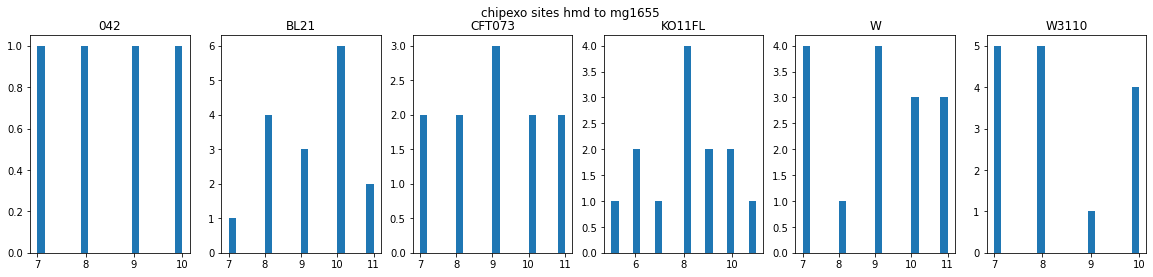

In [39]:
name_to_id = {}
for ID in id_to_name.keys():
    name_to_id[ id_to_name[ID]] = ID
temp_list = ['042','BL21','CFT073','KO11FL','W','W3110']   
fig,axs = plt.subplots(1,6,figsize=(20,4))
for i in range(len(temp_list)):
    strain_name =temp_list[i]
    strain_id = name_to_id[strain_name]
    sn_table = Fur_multi_table[strain_name]
    strain_tu = list( set( sn_table['tu_name'] ) )
    mg_tu = list( set(mg1655_SN['TU']) )
    common_tus = list( set(strain_tu) & set(mg_tu) )
    keep_strain = []
    keep_mg = []
    for k in range(len(sn_table['tu_name'])):
        if list(sn_table['tu_name'])[k] in common_tus:
            keep_strain.append(k)
    for j in range(len(mg1655_SN['TU'])):
        if list(mg1655_SN['TU'])[j] in common_tus:
            keep_mg.append(j)
    sub_mg_pd = mg1655_SN.iloc[keep_mg,:]
    sub_mg_pd = sub_mg_pd.rename(columns={'TU':'tu_name'})
    sub_strain_pd = sn_table.iloc[keep_strain,:]
    merge_sub = sub_strain_pd.merge(sub_mg_pd, on='tu_name')
    merge_sub = merge_sub.dropna()
    hmds = []
    for m in range( len(merge_sub['stop'])):
        if abs( list(merge_sub['stop'])[m] - list(merge_sub['start'])[m] )  == abs( list(merge_sub['ChIP-exo End'])[m] - list(merge_sub['ChIP-exo Start'])[m] ):
            seq1 = bitomes_by_id[strain_id].sequence[ int(merge_sub['ChIP-exo Start'][m]): int(merge_sub['ChIP-exo End'][m]) ]
            seq2 = mg1655.sequence[int(merge_sub['start'][m]): int(merge_sub['stop'][m]) ]
            hmds.append( hmd(str(seq1),str(seq2)) )
            
    
    axs[i].hist( hmds,bins = 20 )
    axs[i].set_title(strain_name )
    
plt.suptitle('chipexo sites hmd to mg1655')
    

In [15]:
pwm_db = rpwm('../data/motif_pwm_db.txt')
pwm_im = rlogodds('../data/motif_logodds.txt')

In [16]:
def find_strand( tu_name ):
    temp = mg1655.tu_table
    temp = temp[temp['name'] == tu_name ]
    if len(temp['strand']) < 1:
        return 0
    strand = temp['strand'][0]
    return int(strand)

def find_tss( tu_name, tu_table ):
    import math
    tu_table = tu_table[tu_table['name'] == tu_name ]
    if len(tu_table['tss']) < 1:
        return 0
    tss = tu_table['tss'][0]
    if math.isnan(tss):
        return 0
    return int(tss)

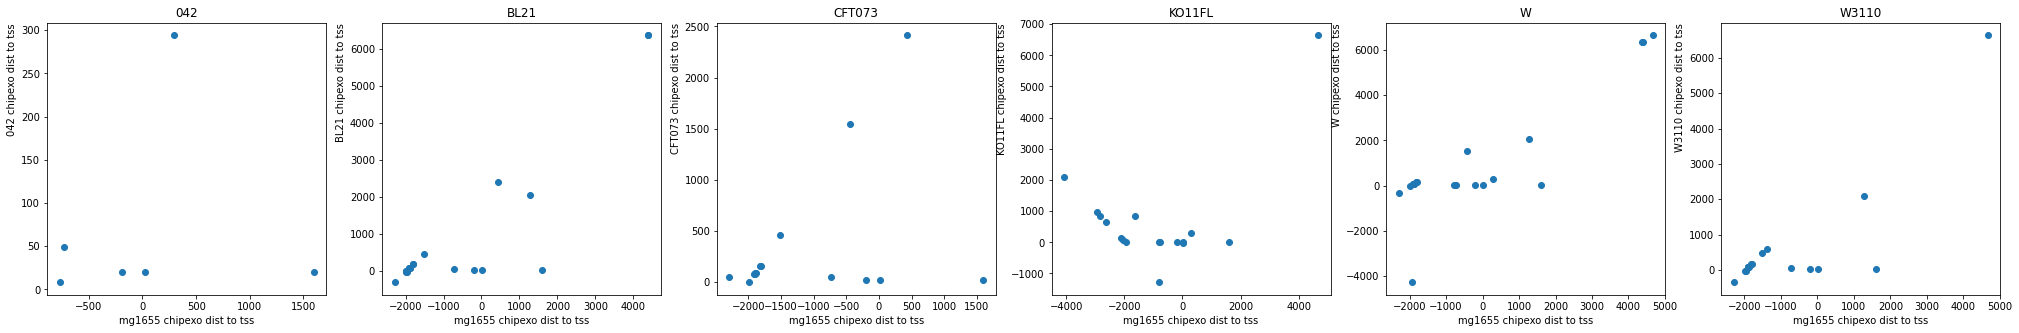

In [42]:
name_to_id = {}
for ID in id_to_name.keys():
    name_to_id[ id_to_name[ID]] = ID
temp_list = ['042','BL21','CFT073','KO11FL','W','W3110']   
fig,axs = plt.subplots(1,6,figsize=(35,5))
for i in range(len(temp_list)):
    strain_name =temp_list[i]
    strain_bitome = bitomes_by_id[  name_to_id[strain_name] ]
    strain_id = name_to_id[strain_name]
    sn_table = Fur_multi_table[strain_name]
    strain_tu = list( set( sn_table['tu_name'] ) )
    mg_tu = list( set(mg1655_SN['TU']) )
    common_tus = list( set(strain_tu) & set(mg_tu) )
    keep_strain = []
    keep_mg = []
    for k in range(len(sn_table['tu_name'])):
        if list(sn_table['tu_name'])[k] in common_tus:
            keep_strain.append(k)
    for j in range(len(mg1655_SN['TU'])):
        if list(mg1655_SN['TU'])[j] in common_tus:
            keep_mg.append(j)
    sub_mg_pd = mg1655_SN.iloc[keep_mg,:]
    sub_mg_pd = sub_mg_pd.rename(columns={'TU':'tu_name'})
    sub_strain_pd = sn_table.iloc[keep_strain,:]
    merge_sub = sub_strain_pd.merge(sub_mg_pd, on='tu_name')
    merge_sub = merge_sub.dropna()
    
    mg_distTSS = []
    strain_distTSS = []
    
    for ind in range( len(merge_sub['tu_name'])):
        mg_site = ( list(merge_sub['stop'])[ind]+ list(merge_sub['start'])[ind] )/2 
        strain_site = ( list(merge_sub['ChIP-exo Start'])[ind]+ list(merge_sub['ChIP-exo End'])[ind] )/2
        
        tu_name = str(merge_sub['tu_name'][ind])
        strand =  find_strand( tu_name )
        if strand == 0:
            continue
        mg_tss = find_tss( tu_name, mg1655.tu_table )
        strain_tss = find_tss( tu_name, strain_bitome.tu_table )
        mg_distTSS.append( mg_site - mg_tss )
        strain_distTSS.append( strain_site - strain_tss )
            
        
    axs[i].scatter( mg_distTSS,strain_distTSS )
    axs[i].set_xlabel('mg1655 chipexo dist to tss')
    axs[i].set_ylabel(strain_name+' chipexo dist to tss',loc='top')
    axs[i].set_title(strain_name )

Text(0.5, 1.0, 'mg1655: chipexo site dist to tss')

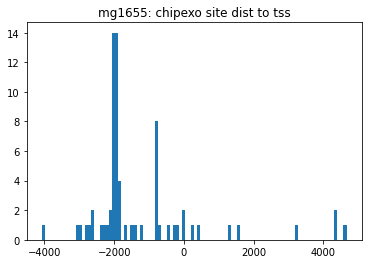

In [43]:
mg_distTSS = []
for i in range(len(mg1655_SN['TU'])):
    tu_name = mg1655_SN['TU'][i]
    site = ( list(mg1655_SN['stop'])[i]+ list(mg1655_SN['start'])[i] )/2 
    mg_tss = find_tss( tu_name, mg1655.tu_table )
    if mg_tss == 0:
        continue
    mg_distTSS.append( site - mg_tss)

plt.hist(mg_distTSS, bins = 100)
plt.title('mg1655: chipexo site dist to tss')

ValueError: max() arg is an empty sequence

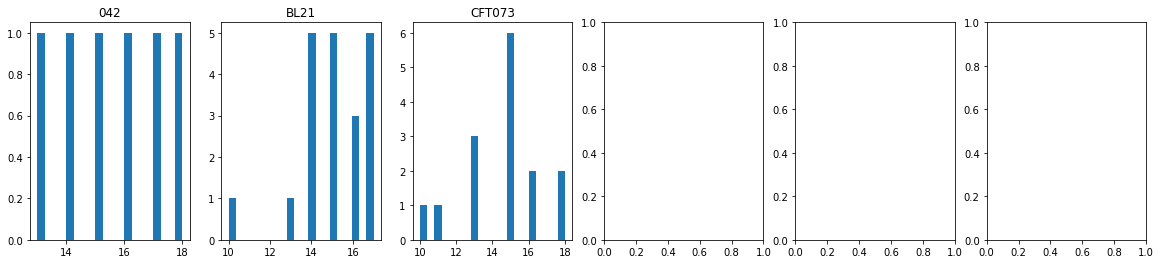

In [42]:
N_up = 40
N_down = 40

name_to_id = {}
for ID in id_to_name.keys():
    name_to_id[ id_to_name[ID]] = ID
temp_list = ['042','BL21','CFT073','KO11FL','W','W3110']   
fig,axs = plt.subplots(1,6,figsize=(20,4))
for i in range(len(temp_list)):
    strain_name =temp_list[i]
    strain_bitome = bitomes_by_id[  name_to_id[strain_name] ]
    strain_id = name_to_id[strain_name]
    sn_table = Fur_multi_table[strain_name]
    strain_tu = list( set( sn_table['tu_name'] ) )
    mg_tu = list( set(mg1655_SN['TU']) )
    common_tus = list( set(strain_tu) & set(mg_tu) )
    keep_strain = []
    keep_mg = []
    for k in range(len(sn_table['tu_name'])):
        if list(sn_table['tu_name'])[k] in common_tus:
            keep_strain.append(k)
    for j in range(len(mg1655_SN['TU'])):
        if list(mg1655_SN['TU'])[j] in common_tus:
            keep_mg.append(j)
    sub_mg_pd = mg1655_SN.iloc[keep_mg,:]
    sub_mg_pd = sub_mg_pd.rename(columns={'TU':'tu_name'})
    sub_strain_pd = sn_table.iloc[keep_strain,:]
    merge_sub = sub_strain_pd.merge(sub_mg_pd, on='tu_name')
    merge_sub = merge_sub.dropna()
    mg_seq = []
    strain_seq = []
    for ind in range( len(merge_sub['tu_name'])):
        mg_site = ( list(merge_sub['stop'])[ind]+ list(merge_sub['start'])[ind] )/2 
        strain_site = ( list(merge_sub['ChIP-exo Start'])[ind]+ list(merge_sub['ChIP-exo End'])[ind] )/2
        
        if mg_site < N_up or strain_site < N_up:
            continue
            
        tu_name = str(merge_sub['tu_name'][ind])
        strand =  find_strand( tu_name )
        if strand == 0:
            continue
            
        mg_result = motif_match_noshape(mg_site, strand, N_up ,N_down, 
                                        strain_bitome, pwm_db, 'Fur', False )
        
        strain_result = motif_match_noshape(strain_site, strand, N_up ,N_down, 
                                        mg1655, pwm_db, 'Fur', False )
        
        mg_seq.append( mg_result['Fur Matched Motif'] )
        strain_seq.append(  strain_result['Fur Matched Motif'] )
    
    hmds = [   hmd(mg_seq[a],strain_seq[a]) for a in range(len(strain_seq))]
    axs[i].hist( hmds,bins = 20 )
    axs[i].set_title(strain_name )

In [ ]:
# check chip sites to TSS and to TFBS matched
# motif match around chipexo sites
#different ref genomes

# Fur seq alignment

# load PSSM and calculate features with no shape

In [44]:
pwm_db = rpwm('../data/motif_pwm_db.txt')
pwm_im = rlogodds('../data/motif_logodds.txt')
N_up = 150
N_down = 30

feature_table = {}
for strain_name in strains_to_check:
    feature = []
    bitome = bitomes_by_id[  name_to_id[strain_name] ]
    tu_table = bitome.tu_table
    for i in range(len(tu_table['name'])):
        data = {}
        data['tu_id'] = tu_table.index[i]
        data['tu_name'] = list(tu_table['name'])[i]
        temp_tss = int(tu_table['tss'][i])
        if temp_tss < 150:
            continue
        strand = int(tu_table['strand'][i])
        data['strand'] = strand
        data.update(  motif_match_noshape( temp_tss , strand , N_up ,N_down, bitome ,pwm_db , 'Fur', False )  )
        data.update(  motif_match_noshape( temp_tss , strand , N_up ,N_down, bitome ,pwm_im , 'Fur-1', True )  )
        data.update(  motif_match_noshape( temp_tss , strand , N_up ,N_down, bitome ,pwm_im , 'Fur-2', True )  )
        feature.append( data )
    feature_table[ strain_name] = pd.DataFrame( feature )

In [45]:
merge_table = {}
for strain_name in strains_to_check:
    f_table = feature_table[strain_name]
    sn_table = Fur_multi_table[strain_name]
    rm_list = []
    for i in range(len(f_table['tu_id'])):
        if f_table['tu_id'][i] not in list(sn_table['tu_id']):
            rm_list.append(i)
    f_table= f_table.drop(rm_list)
    f_table = f_table.reset_index()
    f_table= f_table.drop(columns=['index'])
    sn_table = sn_table.merge(f_table, on='tu_id')
    merge_table[strain_name] = sn_table

In [46]:
from math import log,exp,inf

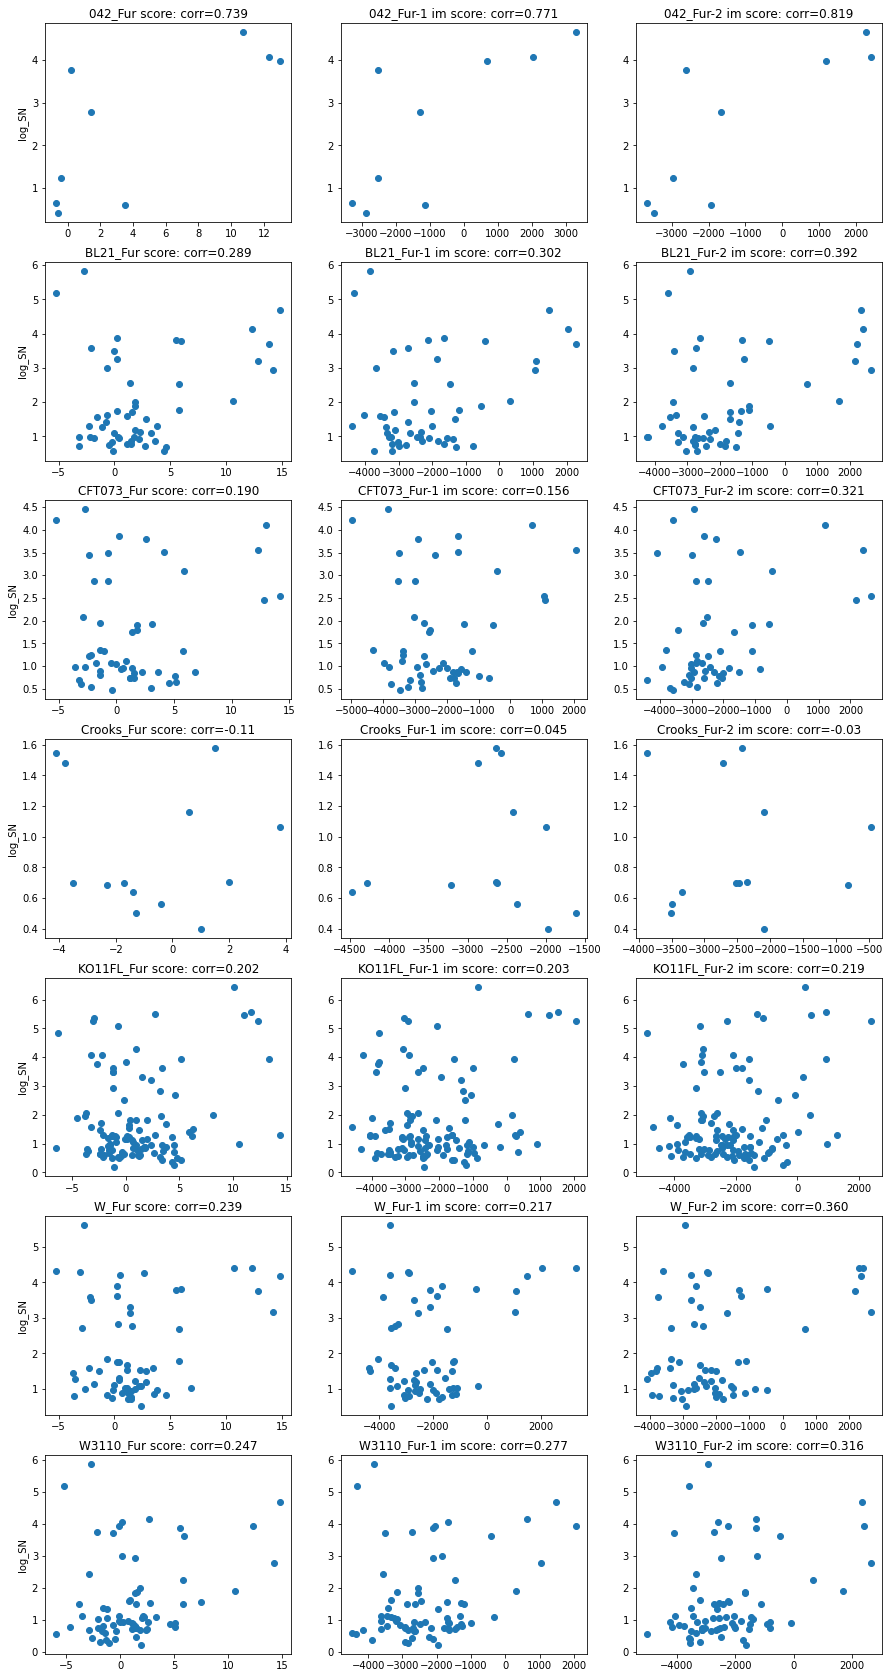

In [47]:
f_list = ['Fur score','Fur-1 im score','Fur-2 im score']
fig,axs = plt.subplots(7,3,figsize=(15,30))
for x in range(len(strains_to_check) ):
    for y in range(len(f_list)):
        strain_name = strains_to_check[x]
        f_name = f_list[y]
        sn = list(merge_table[strain_name]['S/N ratio'] )
        log_sn = [ log(v) for v in sn]
        score = list(merge_table[strain_name][f_name])
        axs[x][y].scatter(score, log_sn)
        corr_txt = str(np.corrcoef( score , log_sn )[0,1])[0:5]
        axs[x][y].set_title( strain_name + '_' + f_name +': corr='+corr_txt)
        if y == 0:
            axs[x][y].set_ylabel('log_SN')

# ML

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_class_weight

In [49]:
X_to_try = {}
y_to_try = {}
f_inds = [7,9,10,11,13,14,15,17,18,19]
for strain_name in strains_to_check:
    if strain_name in ['042','Crooks','CFT073','BL21']:
        continue
    temp = merge_table[strain_name]
    tempX = temp.iloc[:,f_inds].values
    tempX = StandardScaler().fit_transform(tempX)
    X_to_try[strain_name] = tempX
    
    sn_ratios = list(temp['S/N ratio'])
    y_label = []
    for sn in sn_ratios:
        if sn > 50:
            y_label.append(1)
        else:
            y_label.append(0)
            
    y_to_try[strain_name] = y_label


models_to_try = {
    'LR': LogisticRegression(
        penalty='l1',
        solver='saga',
        class_weight='balanced',
        random_state=42
    ),
    'SVM': LinearSVC(
        penalty='l1',
        class_weight='balanced',
        dual=False,
        random_state=42,
        verbose=1
    )
}

In [31]:
hyperopt_models = {
    'LR': {
        'model': LogisticRegression(
            solver='saga',
            class_weight='balanced',
            verbose=1
        ),
        'param_dists': {
            'penalty': ['l1', 'l2'],
            'C': np.arange(0.01, 5, 0.05),
            'max_iter':np.array([100,200,500,1000,1500,2000])
        }
    },
    'SVM': {
        'model': LinearSVC(
            class_weight='balanced',
            dual=False,
            verbose=1
        ),
        'param_dists': {
            'penalty': ['l1', 'l2'],
            'loss': ['hinge', 'squared_hinge'],
            'C': np.arange(0.01, 5, 0.05)
        }
    }
}

In [51]:
result_df = pd.DataFrame(
    columns=['model', 'strain', 'train_auc', 'test_auc']
)

N_CV = 5

for model_name, model in models_to_try.items():
    print(f'{model_name}')
    
    for y_name, y_labels in y_to_try.items():
        print(f'{model_name}: {y_name}')
        
        cv_result = cross_validate(
            model,
            X_to_try[y_name],
            y= y_labels,
            cv=N_CV,
            scoring='roc_auc',
            return_train_score=True,
            verbose=1,
            n_jobs=4
        )

        sub_result_df = pd.DataFrame(
            data={
                'model': [model_name] * N_CV,
                'strain': [y_name] * N_CV,
                'train_auc': cv_result['train_score'],
                'test_auc': cv_result['test_score']
            }
        )

        result_df = result_df.append(sub_result_df)

LR
LR: KO11FL


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: W
LR: W3110
SVM
SVM: KO11FL
SVM: W
SVM: W3110


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


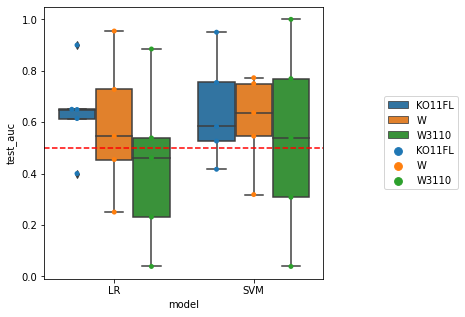

In [55]:
_, ax = plt.subplots(figsize=(5,5))
sns.swarmplot(x='model', y='test_auc', data=result_df, hue='strain', dodge=True, ax=ax)
sns.boxplot(x='model', y='test_auc', data=result_df, hue='strain', dodge=True, ax=ax)
plt.legend(loc='right', bbox_to_anchor=(1.5, 0.5))
plt.axhline(y= 0.5, color = 'r', ls = '--')

In [56]:
# try sites in 042
# check regulation types
# -2000 shift in K12 data. different strain

In [57]:
hyperopt_SVM = {}

for y_name, y_labels in y_to_try.items():
    print(y_name)

    random_search_hyperopt = RandomizedSearchCV(
        hyperopt_models['SVM']['model'],
        hyperopt_models['SVM']['param_dists'],
        n_iter=25,
        scoring='roc_auc',
        n_jobs=4,
        cv=5,
        verbose=1,
        return_train_score=True
    )

    random_search_hyperopt.fit( X_to_try[y_name],y_labels )
    
    hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
        by='mean_test_score',
        ascending=False
    )
    hyperopt_SVM[y_name] = hyperopt_results_df

# combine all the hyperopt results into a DF
dfs_with_ims = []
for y_name, hyperopt_df in hyperopt_SVM.items():
    hyperopt_df['strain'] = [y_name] * hyperopt_df.shape[0]
    dfs_with_ims.append(hyperopt_df)

hyperopt_SVM_df = pd.concat(dfs_with_ims, axis=0, ignore_index=True)

KO11FL
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]W
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]W3110
Fitting 5 folds for each of 25 candidates, totalling 125 fits
[LibLinear]

[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.6s finished


Text(0.5, 1.0, 'SVM: Fur SN_ratio')

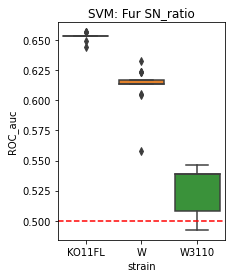

In [58]:
plt.figure( figsize=(3,4))
#sns.swarmplot(x='strain', y='mean_train_score', data=hyperopt_SVM_df)
sns.boxplot(x='strain', y='mean_test_score', data=hyperopt_SVM_df)
plt.axhline(y= 0.5, color = 'r', ls = '--')
plt.ylabel('ROC_auc')
plt.title('SVM: Fur SN_ratio')

In [59]:
hyperopt_LR = {}

for y_name, y_labels in y_to_try.items():
    print(y_name)

    random_search_hyperopt = RandomizedSearchCV(
        hyperopt_models['LR']['model'],
        hyperopt_models['LR']['param_dists'],
        n_iter=25,
        scoring='roc_auc',
        n_jobs=4,
        cv=5,
        verbose=1,
        return_train_score=True
    )

    random_search_hyperopt.fit( X_to_try[y_name],y_labels )
    
    hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
        by='mean_test_score',
        ascending=False
    )
    hyperopt_LR[y_name] = hyperopt_results_df

# combine all the hyperopt results into a DF
dfs_with_ims = []
for y_name, hyperopt_df in hyperopt_LR.items():
    hyperopt_df['strain'] = [y_name] * hyperopt_df.shape[0]
    dfs_with_ims.append(hyperopt_df)

hyperopt_LR_df = pd.concat(dfs_with_ims, axis=0, ignore_index=True)

KO11FL
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    9.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
W
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 118 out of 125 | elapsed:    7.9s remaining:    0.5s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    8.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent w

max_iter reached after 0 seconds
W3110
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 118 out of 125 | elapsed:    4.6s remaining:    0.3s


max_iter reached after 0 seconds


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Text(0.5, 1.0, 'LR: Fur SN_ratio')

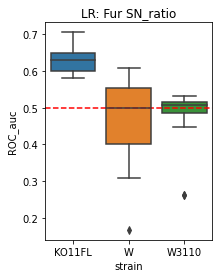

In [60]:
plt.figure( figsize=(3,4))
#sns.swarmplot(x='strain', y='mean_train_score', data=hyperopt_SVM_df)
sns.boxplot(x='strain', y='mean_test_score', data=hyperopt_LR_df)
plt.axhline(y= 0.5, color = 'r', ls = '--')
plt.ylabel('ROC_auc')
plt.title('LR: Fur SN_ratio')

## find better motifs

In [32]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

In [38]:
def find_strand_byid( tu_id ):
    temp = mg1655.tu_table
    temp = temp[temp.index == tu_id ]
    if len(temp['strand']) < 1:
        return 0
    strand = temp['strand'][0]
    return int(strand)

In [68]:
fur_records = {'W':[],'W3110':[],'KO11FL':[]}
for strain_name in fur_records.keys():
    temp_pd = Fur_multi_table[strain_name]
    for i in range(len(temp_pd['ChIP-exo Start'])):
        tuid = temp_pd['tu_id'][i]
        tuname = temp_pd['tu_name'][i]
        strand = find_strand_byid( tuid )
        left = temp_pd['ChIP-exo Start'][i]
        right = temp_pd['ChIP-exo End'][i]
        if strand == 1:
            temp_seq = str( bitomes_by_id[  name_to_id[strain_name] ].sequence[int(left - 30): int(right+31)] )
        else:
            temp_seq = str( bitomes_by_id[  name_to_id[strain_name] ].sequence[int(left - 30): int(right+31)] )
            temp_seq = complement(revstrand(temp_seq) )
            
        fur_records[strain_name].append(  SeqRecord(Seq( temp_seq ), 
                                        id = tuid, name = tuname, description='' )  )  

In [69]:
SeqIO.write(fur_records['W'],'../MEME_results/Fur_ChIP_W/Fur_ChIP_W.fasta','fasta')

62

In [70]:
SeqIO.write(fur_records['W3110'],'../MEME_results/Fur_ChIP_W3110/Fur_ChIP_W3110.fasta','fasta')

72

In [71]:
SeqIO.write(fur_records['KO11FL'],'../MEME_results/Fur_ChIP_KO11FL/Fur_ChIP_KO11FL.fasta','fasta')

113

## Work with new motifs

In [67]:
fur_locustags= {'W':'ECW_RS03750','W3110':'Y75_RS03520','KO11FL':'KO11_RS21270',
                'BL21':'ECD_RS03275','042':'EC042_RS03685'}

fur_pro_seqs = {'W':"MTDNNTALKKAGLKVTLPRLKILEVLQEPDNHHVSAEDLYKRLIDMGEEIGLATVYRVLNQFDDAGIVTRHNFEGGKSVFELTQQHHHDHLICLDCGKVIEFSDDSIEARQREIAAKHGIRLTNHSLYLYGHCAEGDCREDEHAHEGK",
            'W3110':"MTDNNTALKKAGLKVTLPRLKILEVLQEPDNHHVSAEDLYKRLIDMGEEIGLATVYRVLNQFDDAGIVTRHNFEGGKSVFELTQQHHHDHLICLDCGKVIEFSDDSIEARQREIAAKHGIRLTNHSLYLYGHCAEGDCREDEHAHEGK",
            'KO11FL':"MTDNNTALKKAGLKVTLPRLKILEVLQEPDNHHVSAEDLYKRLIDMGEEIGLATVYRVLNQFDDAGIVTRHNFEGGKSVFELTQQHHHDHLICLDCGKVIEFSDDSIEARQREIAAKHGIRLTNHSLYLYGHCAEGDCREDEHAHEGK",
            'BL21':"MTDNNTALKKAGLKVTLPRLKILEVLQEPDNHHVSAEDLYKRLIDMGEEIGLATVYRVLNQFDDAGIVTRHNFEGGKSVFELTQQHHHDHLICLDCGKVIEFSDDSIEARQREIAAKHGIRLTNHSLYLYGHCAEGDCREDEHAHEGK",
            '042':"MTDNNTALKKAGLKVTLPRLKILEVLQEPDNHHVSAEDLYKRLIDMGEEIGLATVYRVLNQFDDAGIVTRHNFEGGKSVFELTQQHHHDHLICLDCGKVIEFSDDSIEARQREIAAKHGIRLTNHSLYLYGHCAEGDCREDEHAHEGK",
            'mg1655':"MTDNNTALKKAGLKVTLPRLKILEVLQEPDNHHVSAEDLYKRLIDMGEEIGLATVYRVLNQFDDAGIVTRHNFEGGKSVFELTQQHHHDHLICLDCGKVIEFSDDSIEARQREIAAKHGIRLTNHSLYLYGHCAEGDCREDEHAHEGK"
}

In [99]:
fur_gene_seqs = {}
for strain_name in fur_locustags.keys():
    bitome = bitomes_by_id[  name_to_id[strain_name] ]
    temp_gtable = bitome.gene_table
    temp_gtable = temp_gtable[temp_gtable.index==fur_locustags[strain_name]]
    left = temp_gtable['left'][0]
    right = temp_gtable['right'][0]
    strand = temp_gtable['strand'][0]
    temp_seq = str( bitome.get_sequence(left,right,strand) )
    fur_gene_seqs[strain_name]=temp_seq
    
temp_gtable = mg1655.gene_table
temp_gtable = temp_gtable[temp_gtable['name']=='fur']
left = temp_gtable['left'][0]
right = temp_gtable['right'][0]
strand = temp_gtable['strand'][0]
temp_seq = str( mg1655.get_sequence(left,right,strand) )
fur_gene_seqs['mg1655']=temp_seq

In [104]:
fur_hmds=[]
for k in fur_locustags.keys():
    fur_hmds.append( hmd(fur_gene_seqs['mg1655'],fur_gene_seqs[k]))

Text(0.5, 1.0, 'Fur gene comparison across strains')

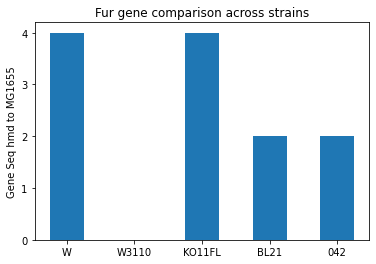

In [117]:
plt.bar(list(fur_locustags.keys()), fur_hmds, width = 0.5)
plt.yticks([0,1,2,3,4]);
plt.ylabel('Gene Seq hmd to MG1655')
plt.title('Fur gene comparison across strains')

### Load new motifs

In [17]:
fur_motifs = rlogodds('../data/Fur_multistrain_SN/Fur_multi_motif.txt')

In [20]:
N_up = 150
N_down = 30
feature_table = {}
for strain_name in strains_to_check:
    feature = []
    bitome = bitomes_by_id[  name_to_id[strain_name] ]
    tu_table = bitome.tu_table
    for i in range(len(tu_table['name'])):
        data = {}
        data['tu_id'] = tu_table.index[i]
        data['tu_name'] = list(tu_table['name'])[i]
        temp_tss = int(tu_table['tss'][i])
        if temp_tss < 150:
            continue
        strand = int(tu_table['strand'][i])
        data['strand'] = strand
        for motif in fur_motifs.keys():
            result = motif_match_noshape( temp_tss , strand , N_up ,N_down, bitome ,fur_motifs ,motif, False )
            result.pop( motif+' Matched Motif')
            data.update(result)
            
        feature.append( data )
        
    feature_table[ strain_name] = pd.DataFrame( feature )
    
merge_table = {}
for strain_name in strains_to_check:
    f_table = feature_table[strain_name]
    sn_table = Fur_multi_table[strain_name]
    rm_list = []
    for i in range(len(f_table['tu_id'])):
        if f_table['tu_id'][i] not in list(sn_table['tu_id']):
            rm_list.append(i)
    f_table= f_table.drop(rm_list)
    f_table = f_table.reset_index()
    f_table= f_table.drop(columns=['index'])
    sn_table = sn_table.merge(f_table, on='tu_id')
    merge_table[strain_name] = sn_table

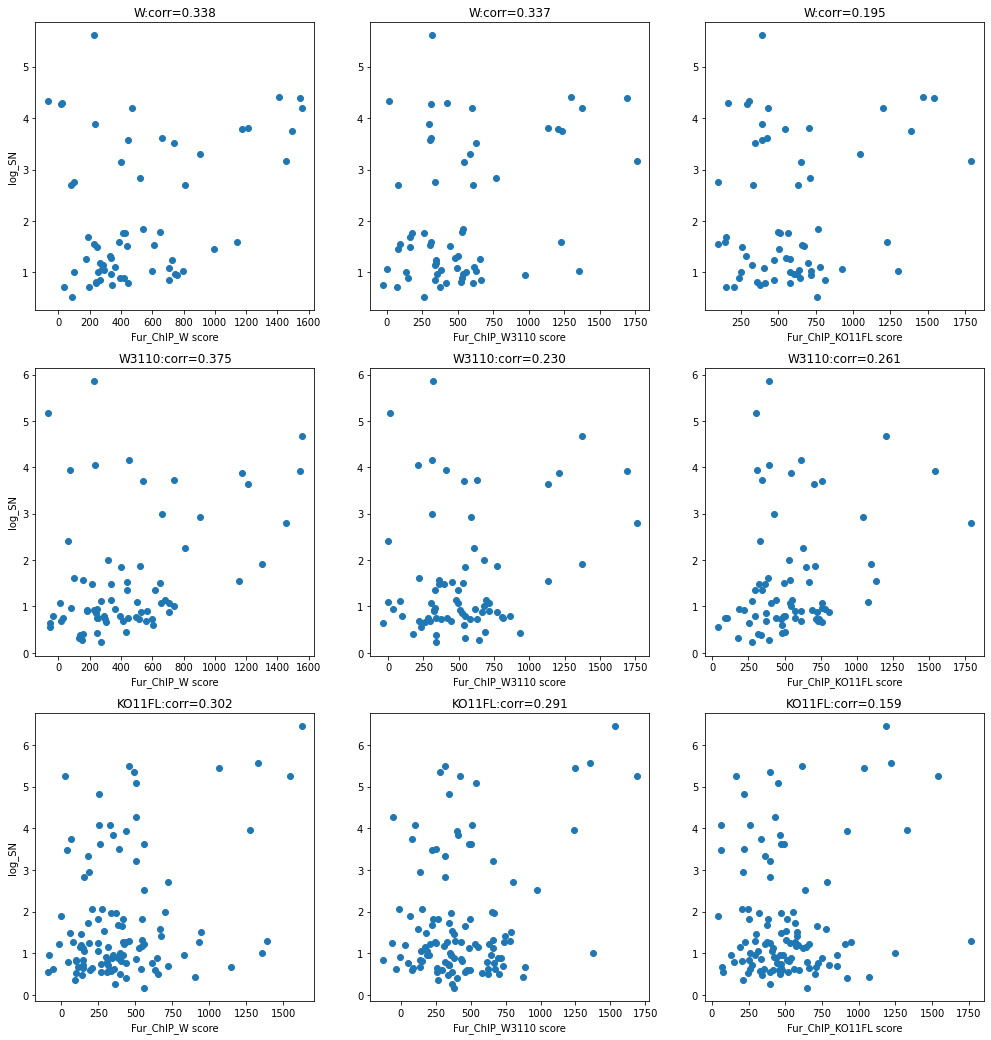

In [57]:
f_list = ['Fur_ChIP_W score','Fur_ChIP_W3110 score','Fur_ChIP_KO11FL score']
temp_s_names = ['W','W3110','KO11FL']
fig,axs = plt.subplots(3,3,figsize=(17,18))
for x in range(3):
    for y in range(len(f_list)):
        strain_name = temp_s_names[x]
        f_name = f_list[y]
        sn = list(merge_table[strain_name]['S/N ratio'] )
        log_sn = [ log(v) for v in sn]
        score = list(merge_table[strain_name][f_name])
        axs[x][y].scatter(score, log_sn)
        corr_txt = str(np.corrcoef( score , log_sn )[0,1])[0:5]
        axs[x][y].set_title( strain_name + ':corr='+corr_txt)
        axs[x][y].set_xlabel( f_name)
        if y == 0:
            axs[x][y].set_ylabel('log_SN')

In [38]:
X_to_try = {}
y_to_try = {}
for strain_name in strains_to_check:
    if strain_name in ['042','Crooks','CFT073','BL21']:
        continue
    temp = merge_table[strain_name]
    tempX = temp.iloc[:,7:].values
    tempX = StandardScaler().fit_transform(tempX)
    X_to_try[strain_name] = tempX
    
    sn_ratios = list(temp['S/N ratio'])
    y_label = []
    for sn in sn_ratios:
        if sn > 50:
            y_label.append(1)
        else:
            y_label.append(0)
            
    y_to_try[strain_name] = y_label


models_to_try = {
    'LR': LogisticRegression(
        penalty='l1',
        solver='saga',
        class_weight='balanced',
        random_state=42
    ),
    'SVM': LinearSVC(
        penalty='l1',
        class_weight='balanced',
        dual=False,
        random_state=42,
        verbose=1
    )
}

In [39]:
result_df = pd.DataFrame(
    columns=['model', 'strain', 'train_auc', 'test_auc']
)

N_CV = 5

for model_name, model in models_to_try.items():
    print(f'{model_name}')
    
    for y_name, y_labels in y_to_try.items():
        print(f'{model_name}: {y_name}')
        
        cv_result = cross_validate(
            model,
            X_to_try[y_name],
            y= y_labels,
            cv=N_CV,
            scoring='roc_auc',
            return_train_score=True,
            verbose=1,
            n_jobs=4
        )

        sub_result_df = pd.DataFrame(
            data={
                'model': [model_name] * N_CV,
                'strain': [y_name] * N_CV,
                'train_auc': cv_result['train_score'],
                'test_auc': cv_result['test_score']
            }
        )

        result_df = result_df.append(sub_result_df)

LR
LR: KO11FL
LR: W
LR: W3110
SVM
SVM: KO11FL


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


SVM: W
SVM: W3110


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


Text(0.5, 1.0, 'strain specific fur motif')

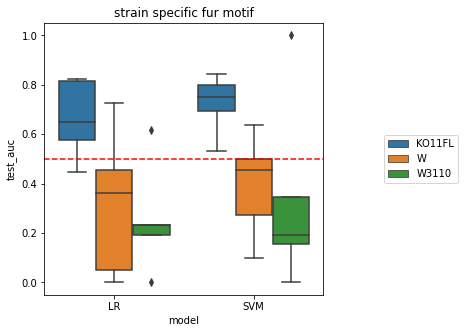

In [41]:
_, ax = plt.subplots(figsize=(5,5))
sns.boxplot(x='model', y='test_auc', data=result_df, hue='strain', dodge=True, ax=ax)
plt.legend(loc='right', bbox_to_anchor=(1.5, 0.5))
plt.axhline(y= 0.5, color = 'r', ls = '--')
plt.title('strain specific fur motif')

In [42]:
hyperopt_models = {
    'LR': {
        'model': LogisticRegression(
            solver='saga',
            class_weight='balanced',
            verbose=1
        ),
        'param_dists': {
            'penalty': ['l1', 'l2'],
            'C': np.arange(0.01, 5, 0.05),
            'max_iter':np.array([100,200,500,1000,1500,2000])
        }
    },
    'SVM': {
        'model': LinearSVC(
            class_weight='balanced',
            dual=False,
            verbose=1
        ),
        'param_dists': {
            'penalty': ['l1', 'l2'],
            'loss': ['hinge', 'squared_hinge'],
            'C': np.arange(0.01, 5, 0.05)
        }
    }
}

In [43]:
hyperopt_SVM = {}

for y_name, y_labels in y_to_try.items():
    print(y_name)

    random_search_hyperopt = RandomizedSearchCV(
        hyperopt_models['SVM']['model'],
        hyperopt_models['SVM']['param_dists'],
        n_iter=25,
        scoring='roc_auc',
        n_jobs=4,
        cv=5,
        verbose=1,
        return_train_score=True
    )

    random_search_hyperopt.fit( X_to_try[y_name],y_labels )
    
    hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
        by='mean_test_score',
        ascending=False
    )
    hyperopt_SVM[y_name] = hyperopt_results_df

# combine all the hyperopt results into a DF
dfs_with_ims = []
for y_name, hyperopt_df in hyperopt_SVM.items():
    hyperopt_df['strain'] = [y_name] * hyperopt_df.shape[0]
    dfs_with_ims.append(hyperopt_df)

hyperopt_SVM_df = pd.concat(dfs_with_ims, axis=0, ignore_index=True)

KO11FL
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    4.8s finished


[LibLinear]W
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]W3110
Fitting 5 folds for each of 25 candidates, totalling 125 fits
[LibLinear]

[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.6s finished


Text(0.5, 1.0, 'SVM: Fur SN_ratio')

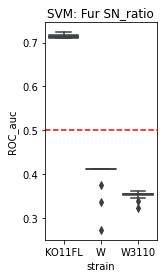

In [49]:
plt.figure( figsize=(2,4))
#sns.swarmplot(x='strain', y='mean_train_score', data=hyperopt_SVM_df)
sns.boxplot(x='strain', y='mean_test_score', data=hyperopt_SVM_df)
plt.axhline(y= 0.5, color = 'r', ls = '--')
plt.ylabel('ROC_auc')
plt.title('SVM: Fur SN_ratio')

In [50]:
hyperopt_LR = {}

for y_name, y_labels in y_to_try.items():
    print(y_name)

    random_search_hyperopt = RandomizedSearchCV(
        hyperopt_models['LR']['model'],
        hyperopt_models['LR']['param_dists'],
        n_iter=25,
        scoring='roc_auc',
        n_jobs=4,
        cv=5,
        verbose=1,
        return_train_score=True
    )

    random_search_hyperopt.fit( X_to_try[y_name],y_labels )
    
    hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
        by='mean_test_score',
        ascending=False
    )
    hyperopt_LR[y_name] = hyperopt_results_df

# combine all the hyperopt results into a DF
dfs_with_ims = []
for y_name, hyperopt_df in hyperopt_LR.items():
    hyperopt_df['strain'] = [y_name] * hyperopt_df.shape[0]
    dfs_with_ims.append(hyperopt_df)

hyperopt_LR_df = pd.concat(dfs_with_ims, axis=0, ignore_index=True)

KO11FL
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 118 out of 125 | elapsed:   12.2s remaining:    0.7s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   13.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


convergence after 62 epochs took 0 seconds
W
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  69 tasks      | elapsed:    6.7s
[Parallel(n_jobs=4)]: Done 118 out of 125 | elapsed:    8.7s remaining:    0.5s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    8.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
W3110
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.2s


max_iter reached after 0 seconds


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    9.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Text(0.5, 1.0, 'LR: Fur SN_ratio')

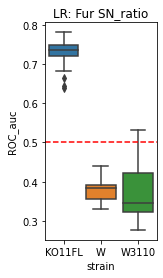

In [58]:
plt.figure( figsize=(2,4))
#sns.swarmplot(x='strain', y='mean_train_score', data=hyperopt_SVM_df)
sns.boxplot(x='strain', y='mean_test_score', data=hyperopt_LR_df)
plt.axhline(y= 0.5, color = 'r', ls = '--')
plt.ylabel('ROC_auc')
plt.title('LR: Fur SN_ratio')